In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from transformers import ViTForImageClassification, ViTConfig

# For confusion matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report
import itertools


/home/mr/workspace/MajorProject/.venv_ensemble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-07 14:59:50.970631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746610191.043764   17272 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746610191.062996   17272 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 14:59:51.227811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in pe

In [2]:
###############################################################################
# 1. Configuration
###############################################################################
data_dir = "../breast_full_dataset"  # Update to your local path
batch_size = 8
train_ratio = 0.8
epochs = 10
lr = 0.5e-6
weight_decay = 1e-4  # Regularization
hdp = 0.2
adp = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
###############################################################################
# 2. Dataset and Transforms
###############################################################################
mean = [0.485, 0.456, 0.406]  # ImageNet means
std = [0.229, 0.224, 0.225]   # ImageNet std

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std),
])

# Augmentation for TRAINING
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize to 224×224
    transforms.RandomVerticalFlip(p=0.5),     # Flip 50% of images
    transforms.RandomRotation(degrees=20),      # Rotate within ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    #transforms.Normalize(mean, std),
])

# Minimal transforms for TEST (no random augmentations)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std),
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = full_dataset.classes
print("Classes found:", class_names)  # e.g. ["benign", "malignant"]

# Split into train/test sets (80/20)
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Wrap them with different transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

print(f"Training samples: {len(train_dataset)}")
print(f"Testing  samples: {len(test_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)


Classes found: ['Benign', 'Malignant']
Training samples: 6105
Testing  samples: 1527


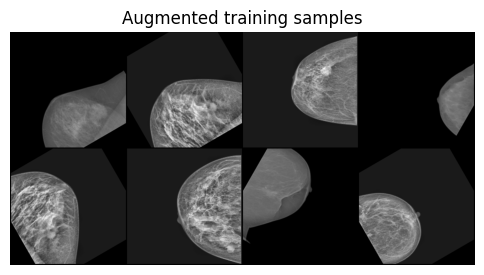

In [4]:
###############################################################################
# 3.  QUICK VISUAL CHECK ‑‑ are my augmentations okay?
###############################################################################
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torchvision import transforms

# If you later add Normalize(mean, std) back into the pipeline
# you’ll need an “inverse” transform to bring values back to [0‑1] RGB.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

def show_batch(data_loader, n_images=16, undo_norm=False):
    """
    Pull one batch from a DataLoader and visualize `n_images` of them in a grid.
    Set `undo_norm=True` if your pipeline has transforms.Normalize(mean, std).
    """
    # 1) Grab a single batch
    imgs, lbls = next(iter(data_loader))           # imgs shape: (B, 3, H, W)
    
    # 2) Optionally de‑normalize (only needed if you called transforms.Normalize)
    if undo_norm:
        imgs = torch.stack([inv_normalize(i) for i in imgs])

    # 3) Clamp to [0,1] for safe viewing and make a grid
    grid = vutils.make_grid(imgs[:n_images], nrow=int(np.sqrt(n_images)), padding=2, normalize=True)

    # 4) Convert CHW→HWC and plot
    plt.figure(figsize=(6,6))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Augmented training samples")
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------------
show_batch(train_loader, n_images=16, undo_norm=False)   # set True if you normalize


In [4]:
"""
B = "../breast_full_dataset/Benign"
M = "../breast_full_dataset/Malignant"
B_dataset = datasets.ImageFolder(root=B, transform=None)
M_dataset = datasets.ImageFolder(root=M, transform=None)
"""

'\nB = "../breast_full_dataset/Benign"\nM = "../breast_full_dataset/Malignant"\nB_dataset = datasets.ImageFolder(root=B, transform=None)\nM_dataset = datasets.ImageFolder(root=M, transform=None)\n'

In [5]:
###############################################################################
# 3. Load Pretrained ViT and Freeze Backbone
###############################################################################
model_name = "google/vit-base-patch16-224-in21k"

# Load the base config from the pretrained model
config = ViTConfig.from_pretrained(model_name, num_labels=2)
# Increase dropout if you want (e.g. from default 0.1 to 0.2)
config.hidden_dropout_prob = hdp
config.attention_probs_dropout_prob = adp

model = ViTForImageClassification.from_pretrained(model_name, config=config)
model.to(device)

# Freeze all layers except the classifier (final head)
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [7]:
###############################################################################
# 4. Optimization Setup
###############################################################################
w0 = len(full_dataset) / (2 * 2520)
w1 = len(full_dataset) / (2 * 5112)

class_weights = torch.tensor([w0, w1], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=weight_decay)


In [8]:
###############################################################################
# 5. Training / Evaluation Functions
###############################################################################
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += images.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += images.size(0)

    epoch_loss = total_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [8]:
###############################################################################
# 6. Main Training Loop (Save Best Model Based on Test Accuracy)
###############################################################################
best_val_acc = 0.0
history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    # Check if this is the best model so far (based on test acc)
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        torch.save(model.state_dict(), f"./models3/t2_breast_vit_NoPreProcess_hdp{hdp}_adp{adp}_lr{lr}-epoch{epoch+1}.pt")
        print(f"Best model saved (acc={best_val_acc*100:.2f}%)")

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f}  | Test  Acc: {test_acc*100:.2f}%")
    print("-" * 50)


Epoch [1/10]


Best model saved (acc=92.86%)
Train Loss: 0.5141 | Train Acc: 75.58%
Test  Loss: 0.2574  | Test  Acc: 92.86%
--------------------------------------------------
Epoch [2/10]


Best model saved (acc=97.51%)
Train Loss: 0.2188 | Train Acc: 91.70%
Test  Loss: 0.1185  | Test  Acc: 97.51%
--------------------------------------------------
Epoch [3/10]


Best model saved (acc=97.90%)
Train Loss: 0.1190 | Train Acc: 96.35%
Test  Loss: 0.0756  | Test  Acc: 97.90%
--------------------------------------------------
Epoch [4/10]


Best model saved (acc=99.15%)
Train Loss: 0.0703 | Train Acc: 97.84%
Test  Loss: 0.0384  | Test  Acc: 99.15%
--------------------------------------------------
Epoch [5/10]


Train Loss: 0.0604 | Train Acc: 98.25%
Test  Loss: 0.0341  | Test  Acc: 99.08%
--------------------------------------------------
Epoch [6/10]


Train Loss: 0.0413 | Train Acc: 98.69%
Test  Loss: 0.0231  | Test  Acc: 99.15%
--------------------------------------------------
Epoch [7/10]


Best model saved (acc=99.74%)
Train Loss: 0.0367 | Train Acc: 98.72%
Test  Loss: 0.0161  | Test  Acc: 99.74%
--------------------------------------------------
Epoch [8/10]


Train Loss: 0.0289 | Train Acc: 99.13%
Test  Loss: 0.0283  | Test  Acc: 99.28%
--------------------------------------------------
Epoch [9/10]


Train Loss: 0.0405 | Train Acc: 98.77%
Test  Loss: 0.0473  | Test  Acc: 98.23%
--------------------------------------------------
Epoch [10/10]


Train Loss: 0.0242 | Train Acc: 99.30%
Test  Loss: 0.0115  | Test  Acc: 99.67%
--------------------------------------------------


In [ ]:

###############################################################################
# 7. Plot Results: Train/Test Accuracy & Loss
###############################################################################
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['test_loss'],  label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in history['train_acc']], label='Train Acc')
plt.plot(epochs_range, [acc * 100 for acc in history['test_acc']],  label='Test Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
###############################################################################
# 8. Confusion Matrix & Classification Report
###############################################################################
# Optionally reload the best model from saved checkpoint
def generate_report(modelname):
    best_model = ViTForImageClassification.from_pretrained(model_name, num_labels=2)
    best_model.load_state_dict(torch.load(modelname))
    best_model.to(device)
    best_model.eval()

    all_preds = []
    all_labels = []

    # Gather predictions on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = best_model(images)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    return cm

# Optional: Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Apply normalization if desired
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]:.2f}", 
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




#### test : hdp&adp : 0.2 | lr : 1e-05

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[491   7]
 [ 95 934]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.84      0.99      0.91       498
   Malignant       0.99      0.91      0.95      1029

    accuracy                           0.93      1527
   macro avg       0.92      0.95      0.93      1527
weighted avg       0.94      0.93      0.93      1527



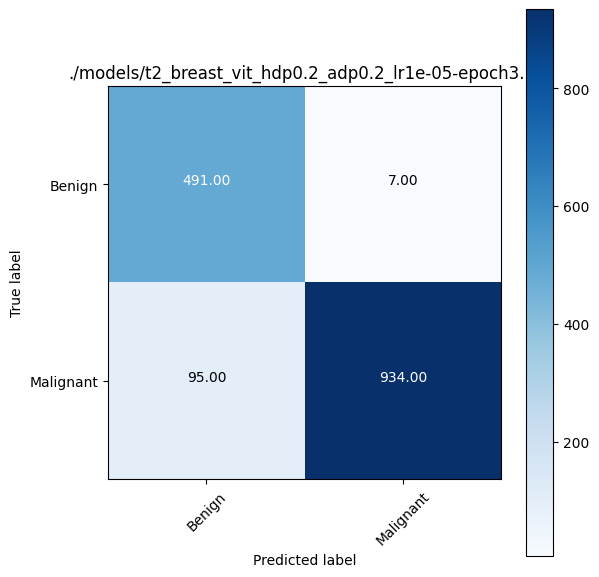

In [14]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr1e-05-epoch3.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[ 492    6]
 [  18 1011]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.98       498
   Malignant       0.99      0.98      0.99      1029

    accuracy                           0.98      1527
   macro avg       0.98      0.99      0.98      1527
weighted avg       0.98      0.98      0.98      1527



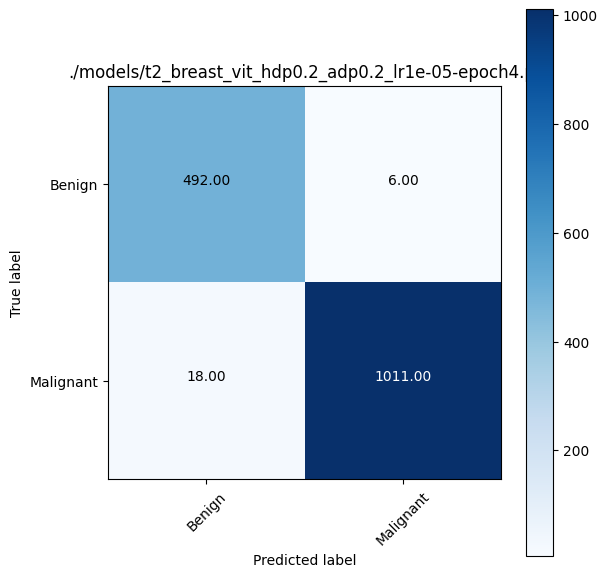

In [15]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr1e-05-epoch4.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

#### test : hdp&adp : 0.2 | lr : 5e-06

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[470  18]
 [525 514]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.47      0.96      0.63       488
   Malignant       0.97      0.49      0.65      1039

    accuracy                           0.64      1527
   macro avg       0.72      0.73      0.64      1527
weighted avg       0.81      0.64      0.65      1527



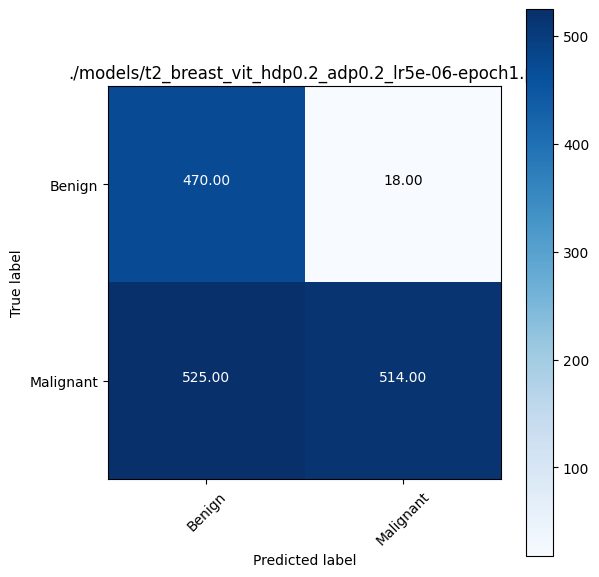

In [9]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr5e-06-epoch1.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[481   7]
 [256 783]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.65      0.99      0.79       488
   Malignant       0.99      0.75      0.86      1039

    accuracy                           0.83      1527
   macro avg       0.82      0.87      0.82      1527
weighted avg       0.88      0.83      0.83      1527



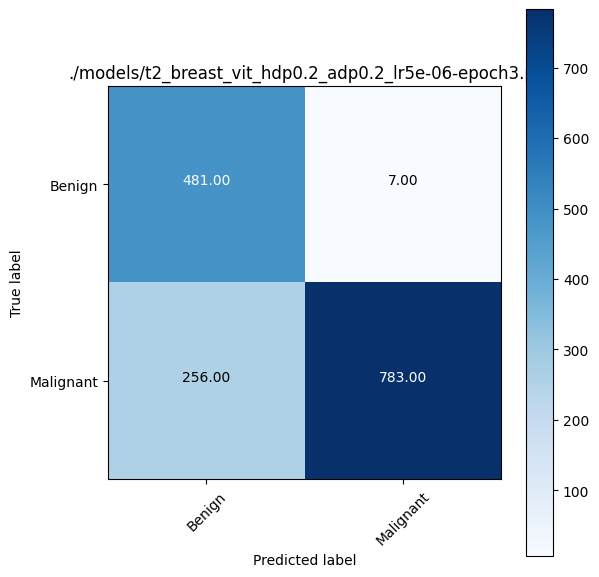

In [10]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr5e-06-epoch3.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[482   6]
 [162 877]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.75      0.99      0.85       488
   Malignant       0.99      0.84      0.91      1039

    accuracy                           0.89      1527
   macro avg       0.87      0.92      0.88      1527
weighted avg       0.91      0.89      0.89      1527



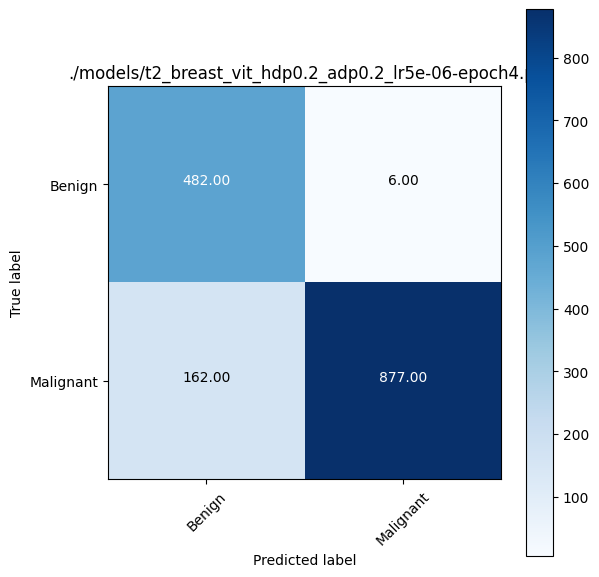

In [11]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr5e-06-epoch4.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[485   3]
 [128 911]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.79      0.99      0.88       488
   Malignant       1.00      0.88      0.93      1039

    accuracy                           0.91      1527
   macro avg       0.89      0.94      0.91      1527
weighted avg       0.93      0.91      0.92      1527



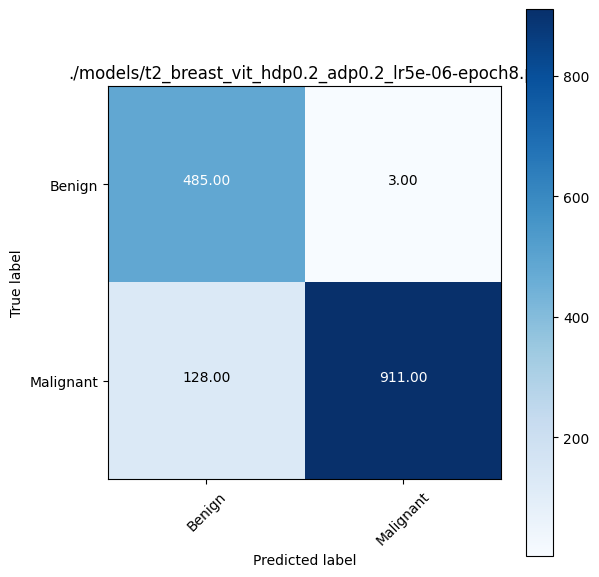

In [12]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr5e-06-epoch8.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[479   9]
 [ 57 982]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.98      0.94       488
   Malignant       0.99      0.95      0.97      1039

    accuracy                           0.96      1527
   macro avg       0.94      0.96      0.95      1527
weighted avg       0.96      0.96      0.96      1527



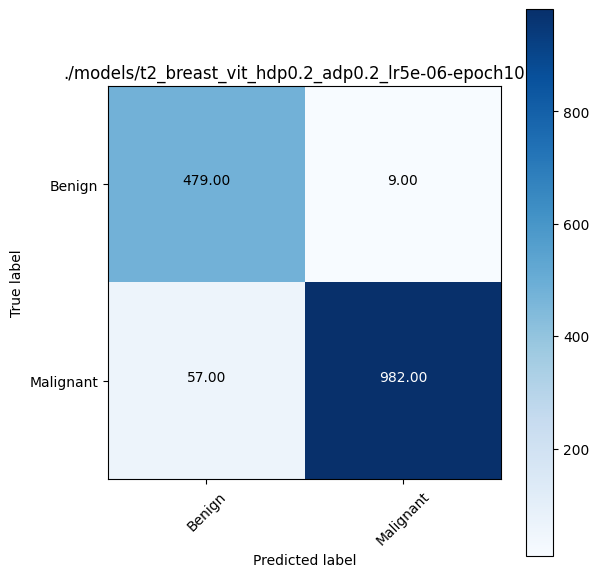

In [13]:
m = "./models/t2_breast_vit_hdp0.2_adp0.2_lr5e-06-epoch10.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

#### test : hdp&adp : 0.3 | lr : 1e-05

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[470  12]
 [683 362]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.41      0.98      0.57       482
   Malignant       0.97      0.35      0.51      1045

    accuracy                           0.54      1527
   macro avg       0.69      0.66      0.54      1527
weighted avg       0.79      0.54      0.53      1527



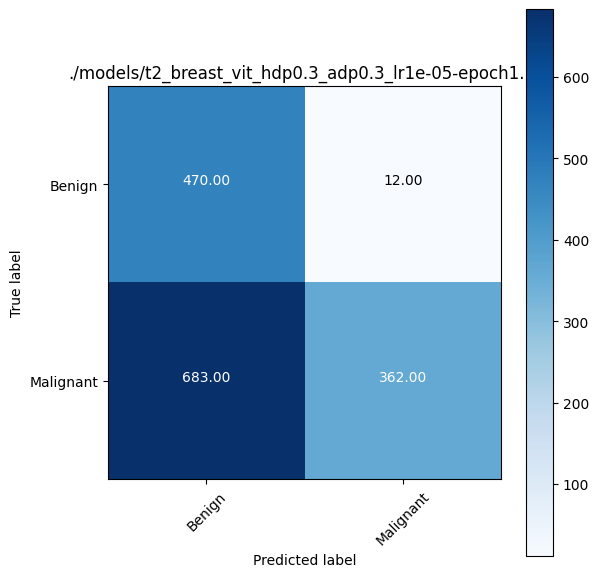

In [10]:
m = "./models/t2_breast_vit_hdp0.3_adp0.3_lr1e-05-epoch1.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[462  20]
 [348 697]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.57      0.96      0.72       482
   Malignant       0.97      0.67      0.79      1045

    accuracy                           0.76      1527
   macro avg       0.77      0.81      0.75      1527
weighted avg       0.85      0.76      0.77      1527



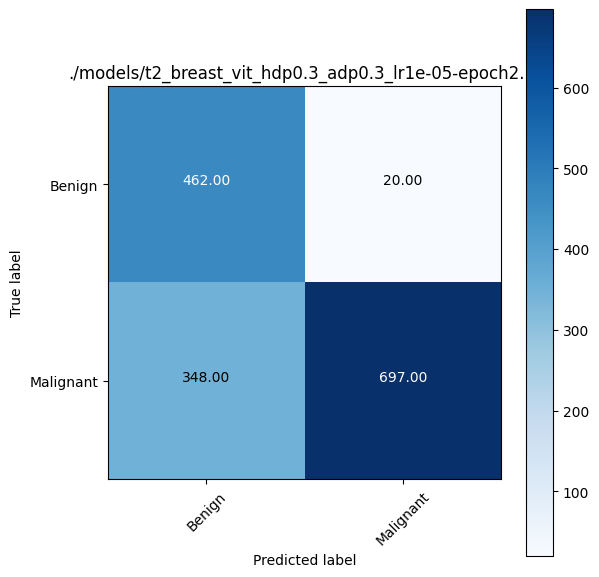

In [11]:
m = "./models/t2_breast_vit_hdp0.3_adp0.3_lr1e-05-epoch2.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[474   8]
 [376 669]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.56      0.98      0.71       482
   Malignant       0.99      0.64      0.78      1045

    accuracy                           0.75      1527
   macro avg       0.77      0.81      0.74      1527
weighted avg       0.85      0.75      0.76      1527



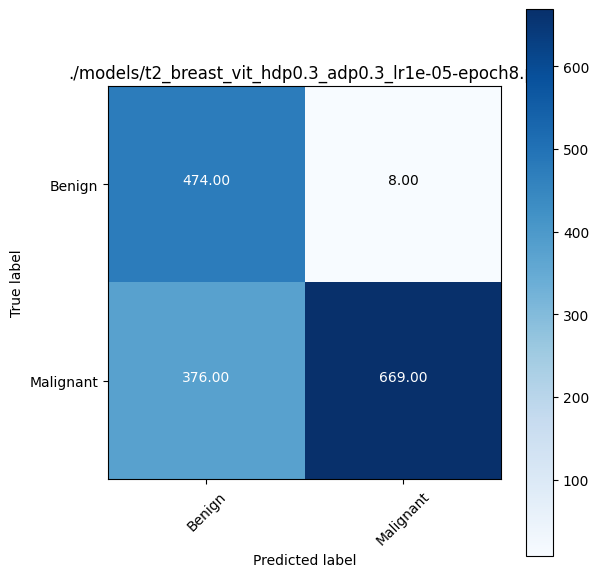

In [12]:
m = "./models/t2_breast_vit_hdp0.3_adp0.3_lr1e-05-epoch8.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[473   9]
 [199 846]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      0.98      0.82       482
   Malignant       0.99      0.81      0.89      1045

    accuracy                           0.86      1527
   macro avg       0.85      0.90      0.86      1527
weighted avg       0.90      0.86      0.87      1527



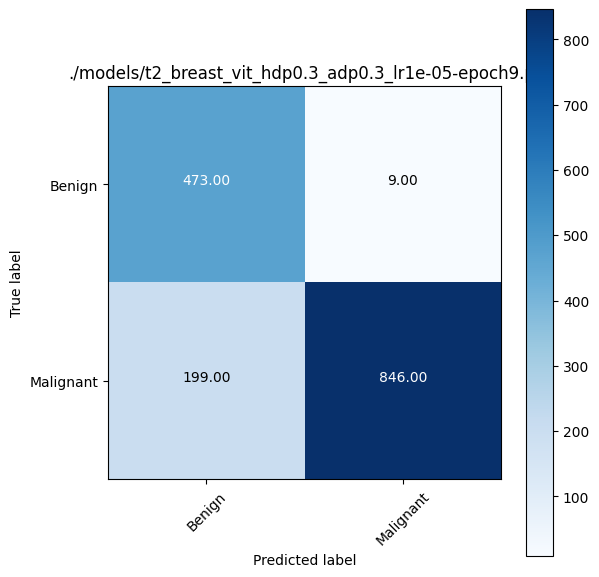

In [13]:
m = "./models/t2_breast_vit_hdp0.3_adp0.3_lr1e-05-epoch9.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

#### test: No Pre Process

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[446  49]
 [ 66 966]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.90      0.89       495
   Malignant       0.95      0.94      0.94      1032

    accuracy                           0.92      1527
   macro avg       0.91      0.92      0.91      1527
weighted avg       0.93      0.92      0.93      1527



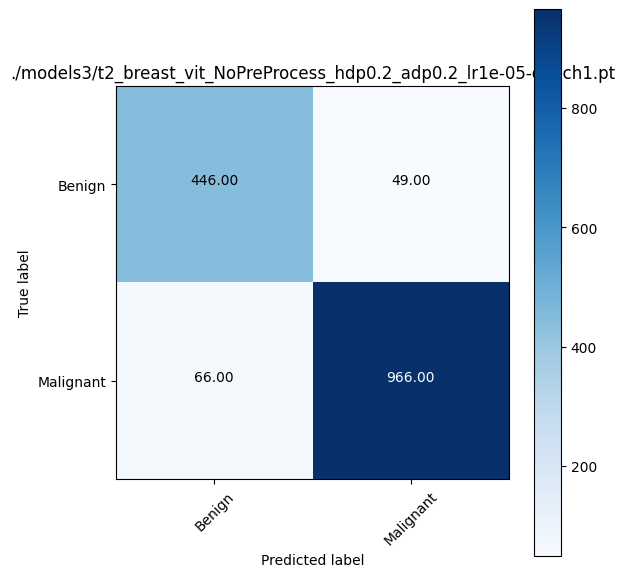

In [12]:
m = "./models3/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch1.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[ 476   19]
 [  11 1021]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97       495
   Malignant       0.98      0.99      0.99      1032

    accuracy                           0.98      1527
   macro avg       0.98      0.98      0.98      1527
weighted avg       0.98      0.98      0.98      1527



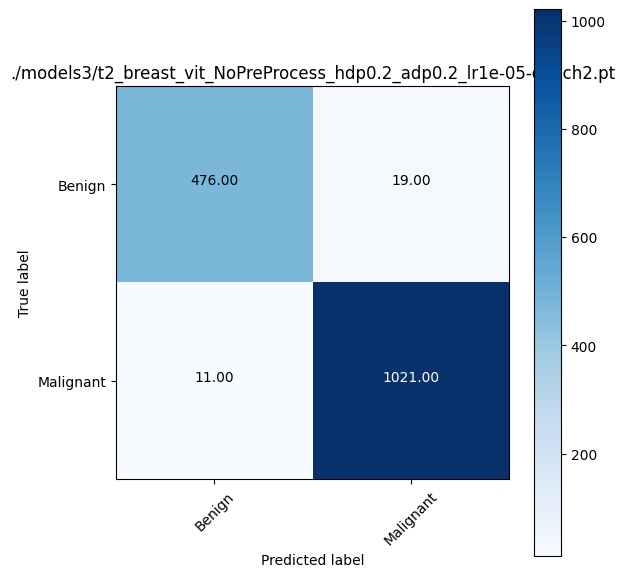

In [13]:
m = "./models3/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch2.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[489   6]
 [ 33 999]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.94      0.99      0.96       495
   Malignant       0.99      0.97      0.98      1032

    accuracy                           0.97      1527
   macro avg       0.97      0.98      0.97      1527
weighted avg       0.98      0.97      0.97      1527



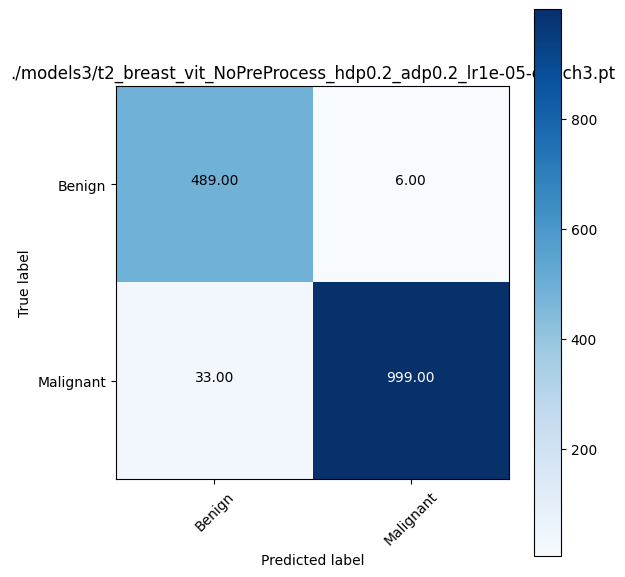

In [14]:
m = "./models3/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch3.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[ 490    5]
 [   4 1028]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99       495
   Malignant       1.00      1.00      1.00      1032

    accuracy                           0.99      1527
   macro avg       0.99      0.99      0.99      1527
weighted avg       0.99      0.99      0.99      1527



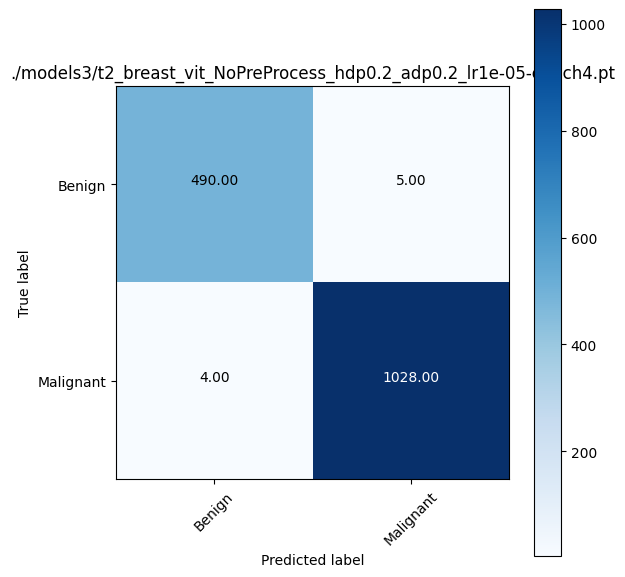

In [15]:
m = "./models3/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch4.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Confusion Matrix:
[[ 493    2]
 [   0 1032]]

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       495
   Malignant       1.00      1.00      1.00      1032

    accuracy                           1.00      1527
   macro avg       1.00      1.00      1.00      1527
weighted avg       1.00      1.00      1.00      1527



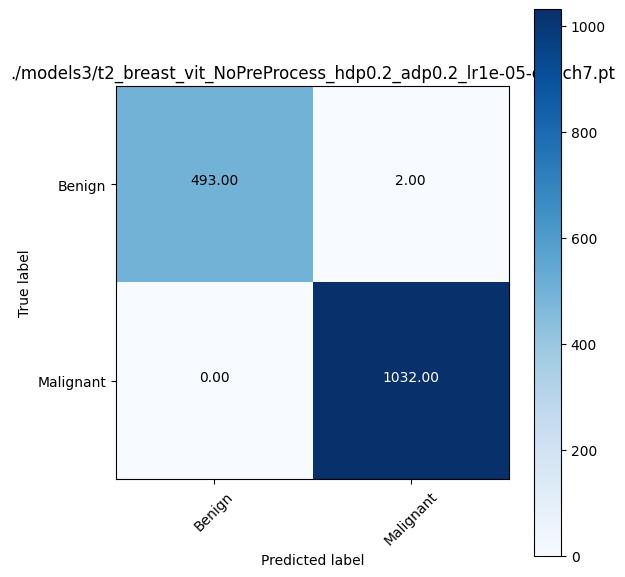

In [16]:
m = "./models3/t2_breast_vit_NoPreProcess_hdp0.2_adp0.2_lr1e-05-epoch7.pt"
cm = generate_report(m)
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cm, classes=class_names, normalize=False, title=m)
plt.show()

## misc

In [10]:
history

{'train_loss': [0.3928715673445386,
  0.06076482967439242,
  0.025693101507293505,
  0.021011401129235115],
 'train_acc': [0.8208026208026208,
  0.9872235872235873,
  0.9965601965601966,
  0.9959049959049959],
 'test_loss': [0.10101416270835929,
  0.024203278907448462,
  0.03470966369877298,
  0.0248342634507436],
 'test_acc': [0.9836280288146693,
  0.9973804846103471,
  0.9947609692206941,
  0.9954158480681073]}

In [11]:
epochs_range

range(1, 5)

Normalized confusion matrix
[[0.99795501 0.00204499]
 [0.04238921 0.95761079]]
              precision    recall  f1-score   support

      Benign       0.92      1.00      0.96       489
   Malignant       1.00      0.96      0.98      1038

    accuracy                           0.97      1527
   macro avg       0.96      0.98      0.97      1527
weighted avg       0.97      0.97      0.97      1527



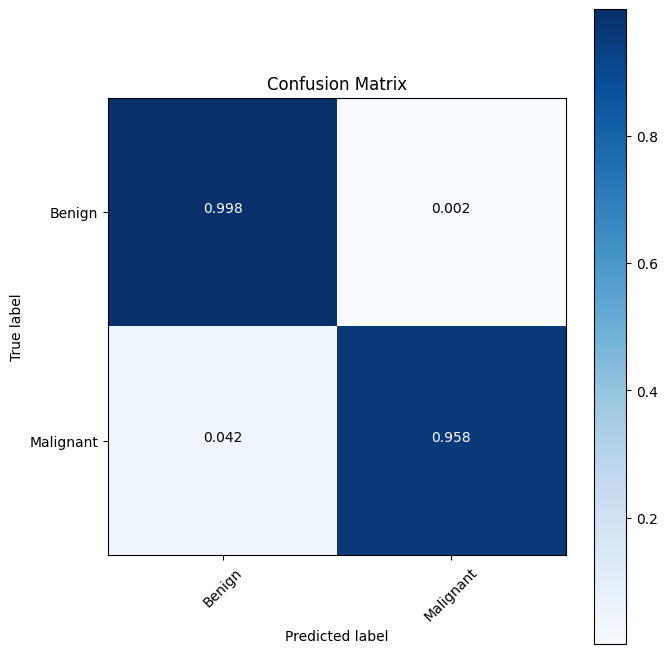

In [18]:
cm = confusion_matrix(all_labels, all_preds)
cm
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=True)
print(classification_report(all_labels, all_preds, target_names=class_names))
